# Testing CNN for imaging fluid flow with streaks analysis
    

## Prepatory steps

Get some includes first and define convenience routines

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import h5py
import time
import torch
import math
import torchvision
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
from numpy import random

%matplotlib inline

use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
print(device)

cuda:0


Load trained networks into pytorch CNN acrhitecture. Note, the architecture that was used for training must be imported here.

In [2]:
from CNN_architectures import StreaksCNN

file_net = 'network_n=1M'

net = StreaksCNN(winSz = 48, filtSz = 5, convPad = 2)
net.load_state_dict(torch.load('networks/%s.pytorch' % file_net))
net.to(device)
net.eval()

StreaksCNN(
  (cnn_part): Sequential(
    (0): Conv2d(1, 8, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (3): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): Conv2d(8, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (5): ReLU()
    (6): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (7): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (9): ReLU()
    (10): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (11): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): Conv2d(32, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (13): ReLU()
    (14): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (dropout): Dropout2d(p=0.2)
  (fc1): Linear(in_features=1152, out_feat

Load data and preprocess

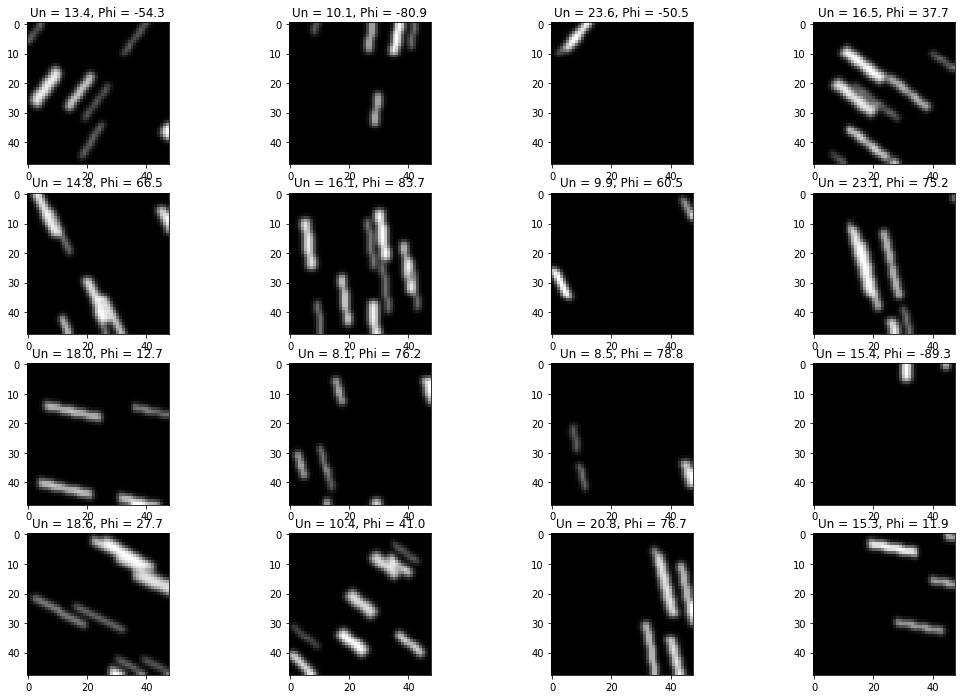

In [3]:
h5f = h5py.File(('networks/%s_data.h5' % file_net), 'r')

testImages = h5f['validationImages'][()]
testData = h5f['validationData'][()]
scale = h5f['scale'][()]
mean = h5f['mean'][()]
windowSize = h5f['windowSize'][()]
h5f.close()

indices = random.randint(0, len(testImages), 16)

fig = plt.figure()
for i in range(indices.size):
    ax = fig.add_subplot(4, 4, i + 1)
    plt.gray()
    plt.imshow(testImages[indices[i],0,:,:])
    ax.set_title("Un = %.1f, Phi = %.1f" % (testData[indices[i],0], testData[indices[i],1]))
    
fig.set_size_inches(np.array(fig.get_size_inches()) * 3)
plt.show()

Preprocess data

((250000, 2), (250000, 2))


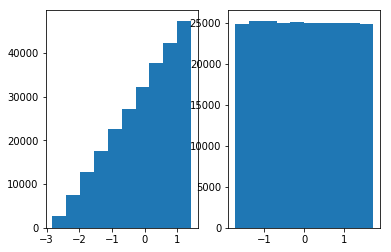

In [4]:
scaler = StandardScaler()
scaler.mean_ = mean
scaler.scale_ = scale

testDataUnit = scaler.transform(testData)

print((testData.shape, testData.shape))

fig = plt.figure()
ax = fig.add_subplot(1,2,1)
plt.hist(testDataUnit[:,0]);
ax = fig.add_subplot(1,2,2)
plt.hist(testDataUnit[:,1]);

## Apply CNN

Apply final network to the validation data set and check accuracy on Un and phi independently

In [10]:
params = {'batch_size': 192,
          'shuffle': False,
          'num_workers': 0}

xtest = torch.from_numpy(testImages / 255).type(torch.FloatTensor)
ytest = torch.from_numpy(testDataUnit).type(torch.FloatTensor)

test_dataset = TensorDataset(xtest, ytest)
test_loader = DataLoader(test_dataset, **params)

ypredicted = np.empty(shape=(0,2))

start_time = time.time()
for inputs, outputs in test_loader:
    # Wrap tensors in Variables
    inputs, outputs = inputs.to(device), outputs.to(device)
            
    # Forward pass
    val_outputs = net(inputs)
    
    if 'cuda' in device.type:
        val_outputs = val_outputs.cpu()
    
    ypredicted = np.concatenate((ypredicted, val_outputs.data.numpy()))
    
elapsed_time = time.time() - start_time
print("Testing finished, took {:.4f}s. {:.2f} images/sec.".format(elapsed_time, len(test_dataset) / elapsed_time))
    
    
ypredicted = scaler.inverse_transform(ypredicted)
yresiduals = ypredicted - testData
yrmse = np.sqrt(np.mean(yresiduals**2, axis = 0))

print('RMSE on Un = ', yrmse[0], ', RMSE on phi = ', yrmse[1])

thrNorm = 2;
thrPhi = 18; 
numCorrectNorm = np.sum(np.abs(yresiduals[:,0]) < thrNorm)
numCorrectPhi = np.sum(np.abs(yresiduals[:,1]) < thrPhi)

accuracy = np.array([numCorrectNorm, numCorrectPhi])/len(yresiduals)
print('Accuracy on Un = ', accuracy[0]*100, '% and on phi = ', accuracy[1]*100, '%')

Testing finished, took 4.1398s. 60388.68 images/sec.
RMSE on Un =  1.0568375586212455 , RMSE on phi =  8.6476552277374
Accuracy on Un =  95.3912 % and on phi =  98.18599999999999 %


Plot a few examples with predictions

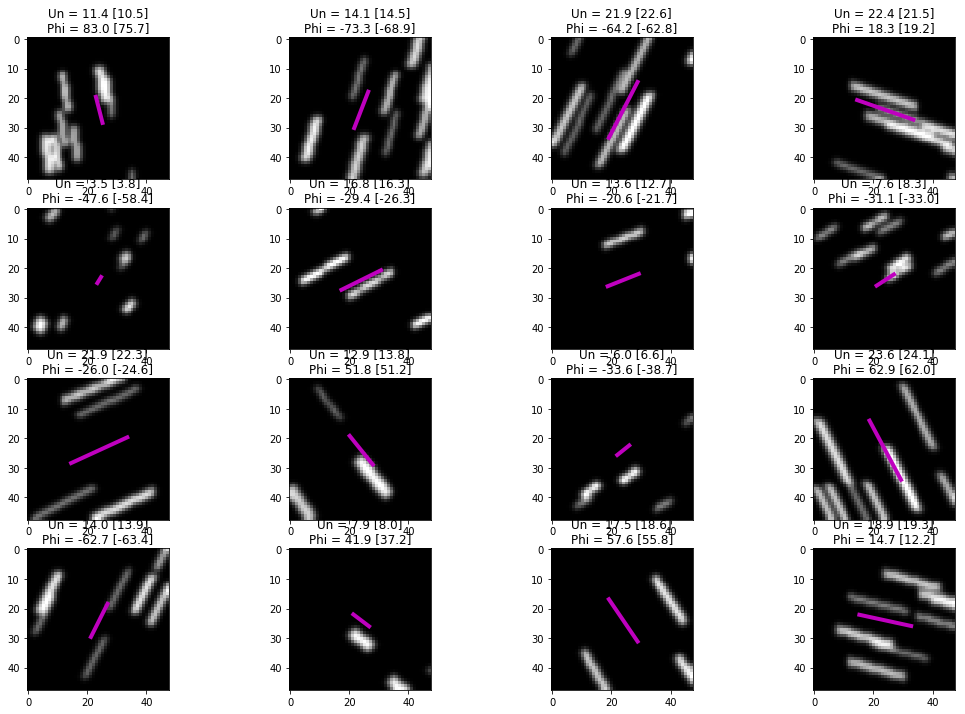

In [6]:
indices = random.randint(0, len(testImages), 16)

fig = plt.figure()
for i in range(indices.size):
    ax = fig.add_subplot(4, 4, i + 1)
    plt.gray()
    plt.imshow(testImages[indices[i],0,:,:])
    ax.set_title("Un = %.1f [%.1f]\nPhi = %.1f [%.1f]" \
                 % (testData[indices[i],0], ypredicted[indices[i],0], \
                    testData[indices[i],1], ypredicted[indices[i],1]))
    
    xc = windowSize / 2
    yc = windowSize / 2
    
    x0 = xc - math.cos(ypredicted[indices[i],1] * np.pi / 180) * ypredicted[indices[i],0] / 2.
    x1 = xc + math.cos(ypredicted[indices[i],1] * np.pi / 180) * ypredicted[indices[i],0] / 2.
    
    y0 = xc - math.sin(ypredicted[indices[i],1] * np.pi / 180) * ypredicted[indices[i],0] / 2.
    y1 = xc + math.sin(ypredicted[indices[i],1] * np.pi / 180) * ypredicted[indices[i],0] / 2.
    
    xy = np.array(([x0, y0], [x1, y1]));
    
    line = patches.Polygon(xy, color = 'm', linewidth = 4)
    
    ax.add_patch(line)
    
fig.set_size_inches(np.array(fig.get_size_inches()) * 3)
plt.show()